In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.ticker as mticker
from matplotlib.table import Table

import os
import numpy as np

import plotly.express as px

## Functions


In [3]:
# Importing Data
def get_comm_prices(symbols_dict, name_dataset):
    """
    Fetches historical prices for the given list of symbols from Yahoo Finance.

    Args:
        symbols (list): List of Yahoo Finance tickers.

    Returns:
        pd.DataFrame: A DataFrame with timestamps as rows and symbols as columns containing prices.
    """
    start_date = (datetime.today() - timedelta(days=730)).strftime('%Y-%m-%d')
    end_date = datetime.today().strftime('%Y-%m-%d')

    df = pd.DataFrame()
    for symbol, name in symbols_dict.items():
        try:
            ticker_data = yf.Ticker(symbol)
            historical_data = ticker_data.history(start=start_date, end=end_date)["Close"]
            historical_data.rename(name, inplace=True)
            df = pd.concat([df, historical_data], axis=1)
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            
    # Format Index to Date
    df.index = pd.to_datetime(df.index)
    df.index.name = "Date"
    
    # Forward Fill All Columns
    df = df.ffill()
            
    # Save the dataset to a CSV file
    df.to_csv(f"../data/raw/{name_dataset}.csv", index=True)

    return df

In [4]:
def merge_csv_files(folder_path, date_column, output_file):
    # Initialize an empty DataFrame
    combined_df = pd.DataFrame()

    # Loop through all CSV files in the specified folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Set the date column as the index
            df[date_column] = pd.to_datetime(df[date_column])
            df.set_index(date_column, inplace=True)
            
            # Merge with the combined DataFrame
            if combined_df.empty:
                combined_df = df
            else:
                combined_df = pd.merge(combined_df, df, left_index=True, right_index=True, how='outer')

    # Decimals
    combined_df = combined_df.round(2)    

    # Save the combined dataset to a CSV file
    combined_df.to_csv(f"../data/processed/{output_file}.csv", index=True)
    print(f"Combined CSV saved to {output_file}")
    
    return combined_df

In [5]:
def calculate_metrics(data, output_csv):
    """
    Calculate Last Value, WoW (%), MoM (%), YTD (%), YoY (%) for a given dataset
    and export the results to a CSV file.
    
    Parameters:
    data (pd.DataFrame): DataFrame with a datetime index and columns for each metric.
    output_csv (str): Path to the output CSV file.
    """
    
    # Ensure the index is a datetime object
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    # Handle timezone-awareness if present
    if hasattr(data.index, 'tz') and data.index.tz is not None:
        data.index = data.index.tz_convert(None)  # Convert to timezone-naive
    
    # Sort by date to ensure calculations are correct
    data = data.sort_index()
    
    # Sort by date to ensure calculations are correct
    data = data.sort_index()
    
    # Last value
    last_row = data.iloc[-1]
    
    # Helper function to find the closest available date
    def get_closest_value(target_date):
        closest_date = data.index[data.index.get_indexer([target_date], method='nearest')[0]]
        return data.loc[closest_date]
    
    # Calculate WoW (%), MoM (%), YTD (%), YoY (%)
    one_day_ago = data.index[-1] - pd.Timedelta(days=1)
    one_week_ago = data.index[-1] - pd.Timedelta(weeks=1)
    one_month_ago = data.index[-1] - pd.DateOffset(months=1)
    
    # Adjust to find the closest match for January 3rd in the index
    start_of_year = data.index[-1] - pd.Timedelta(weeks=3)

    one_year_ago = data.index[-1] - pd.DateOffset(years=1)
    
    metrics = {
        "Last Value": last_row.round(4),
        "Daily (%)": ((last_row - get_closest_value(one_day_ago)) / get_closest_value(one_day_ago) * 100),
        "WoW (%)": ((last_row - get_closest_value(one_week_ago)) / get_closest_value(one_week_ago) * 100),
        "MoM (%)": ((last_row - get_closest_value(one_month_ago)) / get_closest_value(one_month_ago) * 100),
        "YTD (%)": ((last_row - get_closest_value(start_of_year)) / get_closest_value(start_of_year) * 100),
        "YoY (%)": ((last_row - get_closest_value(one_year_ago)) / get_closest_value(one_year_ago) * 100)
    }

    # Combine all metrics into a single DataFrame
    result_df = pd.DataFrame(metrics).round(3)
    
    result_df = result_df.sort_values(by="WoW (%)", ascending=False)

    # Export to CSV
    result_df.to_csv(f"../data/processed/{output_csv}", index_label="Commodity")
    print(f"Metrics saved to {output_csv}")

In [6]:
def plot_wow_change(data, file_name, title_chart):
    """
    Plots a bar chart of week-over-week (WoW) percentage change and labels it with close values.

    Args:
        data (pd.DataFrame): The dataset containing the price columns and a datetime index.
        file_name (str): The name of the file for saving the chart.
    """
    # Ensure the index is a datetime index
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The dataset index must be a DatetimeIndex.")
    
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Black.ttf'
    
    # Register the font properties
    prop = fm.FontProperties(fname=font_path)
    prop_bold = fm.FontProperties(fname=font_path_bold)

    # Select the last week of data
    last_week = data.iloc[-5:]

    # Calculate WoW percentage change
    wow_change = (last_week.iloc[-1] - last_week.iloc[0]) / last_week.iloc[0] * 100

    # Sort by the biggest change
    wow_change = wow_change.sort_values(ascending=False)

    # Define improved bar colors: appreciation and depreciation
    appreciation = "#5a65cf"  
    depreciation = "#FFA500"  
    bar_colors = [appreciation if value > 0 else depreciation for value in wow_change.values]

    # Create bar chart
    plt.figure(figsize=(8.27, 2.8))  # Adjusted height for better visibility
    bars = plt.bar(wow_change.index, wow_change.values, color=bar_colors, edgecolor="black", linewidth=0.8)

    # Add labels with the percent change and close value for the last day of the week
    for bar, change, label in zip(bars, wow_change.values, last_week[wow_change.index].iloc[-1]):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() / 2, 
            f"{change:.2f}%\n({label:.2f})", 
            ha="center", 
            va="center", 
            fontsize=12, 
            color="white" if change > 0 else "black", 
            fontproperties=prop
        )

    # Customize plot with improved layout
    plt.title(f"Week-over-Week % Change for {title_chart}", fontproperties=prop_bold, size=16)
    plt.ylabel("(%)", fontproperties=prop_bold, size=9, color="#333333")
    plt.xticks(fontproperties=prop_bold, size=9, rotation=45, color="#333333")
    plt.yticks(fontproperties=prop, size=9, color="#333333")
    plt.axhline(0, color="#666666", linewidth=0.8, linestyle="--")  # Subtle horizontal line at 0
    plt.tight_layout()

    # Ensure the folder exists
    export_path = f"../report/images/{file_name}"
    os.makedirs(os.path.dirname(export_path), exist_ok=True)
    
    # Prepare the export file path
    export_file_path = export_path.replace(" ", "_") + ".png"
    
    # Save the chart
    plt.savefig(export_file_path, format="png", dpi=300, bbox_inches="tight")
    print(f"Chart saved to {export_file_path}")

    # Show plot
    plt.show()

## Importing Datasets

In [7]:
# List of Yahoo Finance tickers for the commodities
symbols_dict = {
    "BZ=F": "Brent",
    "CL=F": "WTI",
    "NG=F": "Nat Gas",
    "HO=F": "HO",
    "RB=F": "RBOB"
}

# Fetch the data and create a dataset
energy_dataset = get_comm_prices(symbols_dict, "energy_commodities")

In [8]:
# List of Yahoo Finance tickers for the commodities
symbols_dict = {
    "KC=F": "Arabic Coffee",
    "CT=F": "Cotton",
    "ZC=F": "Corn",
    "ZS=F": "Soybean",
    "SB=F": "White Sugar",
    "LE=F": "Live Cattle"
}

# Fetch the data and create a dataset
agricultural_dataset = get_comm_prices(symbols_dict, "agricultural_commodities")

In [9]:
# List of Yahoo Finance tickers for the commodities
symbols_dict = {
    "GC=F": "Gold",
    "SI=F": "Silver",
    "HG=F": "Copper",
    "ALI=F": "Aluminium",
}

# Fetch the data and create a dataset
metals_dataset = get_comm_prices(symbols_dict, "metals_commodities")

## General Table

In [10]:
# Example usage
folder_path = '../data/raw/'
date_column = 'Date'  # Replace with the actual name of your date column
combined_dataset = merge_csv_files(folder_path, date_column, "all_commodities")
print(combined_dataset)

file_path = "../data/processed/all_commodities.csv"  # Replace with your file path
data = pd.read_csv(file_path, index_col="Date")

# Call the function
output_path = "metrics_output.csv"  # Replace with your desired output file path
calculate_metrics(data, output_path)

Combined CSV saved to all_commodities
                             Gold  Silver  Copper  Aluminium  Arabic Coffee  \
Date                                                                          
2023-02-09 00:00:00-05:00  1866.2   22.10    4.11    2487.50         173.65   
2023-02-10 00:00:00-05:00  1862.8   22.03    4.03    2429.00         174.75   
2023-02-13 00:00:00-05:00  1851.9   21.82    4.09    2389.00         177.05   
2023-02-14 00:00:00-05:00  1854.0   21.84    4.11    2381.00         183.55   
2023-02-15 00:00:00-05:00  1834.2   21.55    4.05    2354.75         176.85   
...                           ...     ...     ...        ...            ...   
2025-02-03 00:00:00-05:00  2833.9   32.39    4.29    2617.00         380.90   
2025-02-04 00:00:00-05:00  2853.3   32.89    4.34    2631.00         383.35   
2025-02-05 00:00:00-05:00  2871.6   32.86    4.43    2601.50         397.75   
2025-02-06 00:00:00-05:00  2856.0   32.52    4.45    2620.75         403.95   
2025-02-07 00:

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_31276/100002966.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[date_column] = pd.to_datetime(df[date_column])
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_31276/100002966.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[date_column] = pd.to_datetime(df[date_column])
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_31276/100002966.py:15: FutureWarn

## Descriptive Analysis

Chart saved to ../report/images/energy_commodities_wow.png


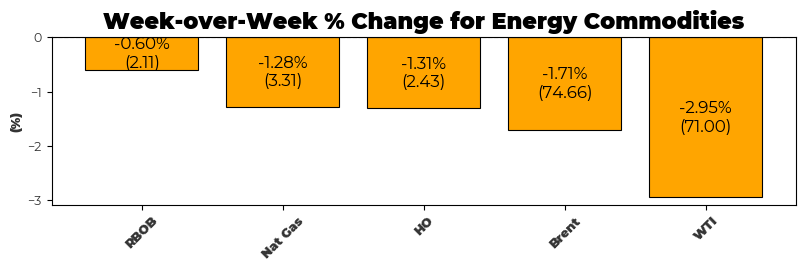

In [11]:
# Use the function
plot_wow_change(energy_dataset, "energy_commodities_wow", "Energy Commodities")

Chart saved to ../report/images/agricultural_commodities_wow.png


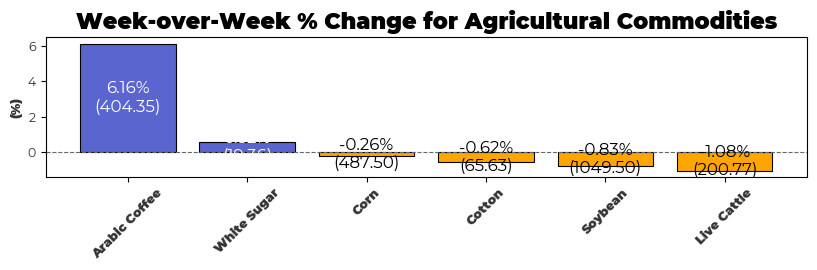

In [12]:
# Use the function
plot_wow_change(agricultural_dataset, "agricultural_commodities_wow", "Agricultural Commodities")

Chart saved to ../report/images/metals_commodities_wow.png


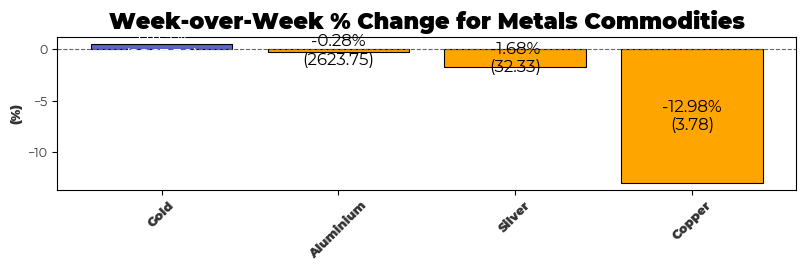

In [13]:
# Use the function
plot_wow_change(metals_dataset, "metals_commodities_wow", "Metals Commodities")

In [14]:
# Load data
commodities_table = pd.read_csv("../data/processed/metrics_output.csv")

# Drop NaN values in "WoW (%)" to avoid errors
commodities_table = commodities_table.dropna(subset=["WoW (%)"])

# Categorize commodities into Positive or Negative
commodities_table["Type"] = commodities_table["WoW (%)"].apply(lambda x: "Appreciation" if x >= 0 else "Depreciation")

# Round WoW (%) to 2 decimal places
commodities_table["WoW (%)"] = commodities_table["WoW (%)"].round(2)

# Normalize size using Log Scaling to prevent small values from disappearing
commodities_table["Size"] = np.log1p(commodities_table["WoW (%)"].abs())  # log(1 + abs(WoW %))

# Create the Treemap
fig = px.treemap(
    commodities_table, 
    path=["Type", "Commodity"],  # Categories
    values="Size",       # Block size based on absolute WoW change
    color="WoW (%)",     # Color reflects actual WoW (%) value
    color_continuous_scale="RdYlGn",  # Red-Yellow-Green scale
    hover_data={"WoW (%)": True},     # Show WoW in hover tooltip
)

# Add percentage labels inside each block
fig.update_traces(
    texttemplate="%{label}<br>%{customdata[0]:.2f}%",  # Shows Commodity name + WoW %
    textfont_size=14,
    textinfo="label+text"  # Ensures text is displayed
)

# Set the figure size (width and height)
fig.update_layout(
    width=1123,  # Adjust width (in pixels)
    height=794,  # Adjust height (in pixels)
    title=" ",
    title_font_size=20
)

# Export as PNG (Ensure you have 'kaleido' installed)
fig.write_image("../report/images/treemap.png")